# Mustererkennung/Machine Learning - Assignment 10 Solution


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
class Classifier:
    
    def accuracy(self, labels, predictions):
        return np.mean(labels == predictions)

In [6]:
training_data = np.array(pd.read_csv('/content/drive/MyDrive/ML_Class_2020/KNN/zip.train', sep=' ', header=None))
test_data = np.array(pd.read_csv('/content/drive/MyDrive/ML_Class_2020/KNN/zip.test', sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

In [7]:
class LinearLayer:
    has_weights = True
    
    def __init__(self, size_in, size_out):
        xavier_init = (2 / (size_in + size_out))
        self.w = np.random.randn(size_in, size_out) * xavier_init
        self.b = np.random.randn(size_out) * xavier_init
        
    def __call__(self, x):
        self.x = x
        return x @ self.w + self.b
    
    def backward(self, g):
        self.grad_w = self.x.T @ g
        self.grad_b = np.sum(g, axis=0)
        return g @ self.w.T

In [8]:
def relu(z, derivative=False):
    if derivative:
        return (z > 0).astype(float)
    return np.clip(z, 0, np.inf)

In [9]:
def sigmoid(z, derivative=False):
    if derivative:
        return sigmoid(z) * (1 - sigmoid(z))
    return 1./(1 + np.exp(-z))

In [10]:
class ActivationLayer:
    has_weights = False
    
    def __init__(self, function):
        self.activation = function
        
    def __call__(self, x):
        self.x = x
        return self.activation(x)
    
    def backward(self, g):
        return self.activation(self.x, derivative=True) * g

In [11]:
class Net:
    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def backward(self, g):
        for layer in reversed(self.layers):
            g = layer.backward(g)

In [12]:
def mse(pred, target, return_grad=True):
    diff = pred - target
    if not return_grad:
        return np.mean(diff ** 2)
    return np.mean(diff ** 2), 2 * diff

In [13]:
def gradient_descent(net, lr):
    for layer in net.layers:
        if layer.has_weights:
            layer.w -= lr * layer.grad_w
            layer.b -= lr * layer.grad_b

In [14]:
class NeuralNetwork(Classifier):
    
    def __init__(self, layers, num_classes):
        self.model = Net(layers)
        self.num_classes = num_classes
        
    def fit(self, num_epochs, X_train, y_train, batch_size=32, lr=1e-3):
        num_datapoints = len(y_train) - len(y_train) % batch_size
        loss_training = []
        loss_test = []
        for epoch in tqdm(range(num_epochs)):
            loss_epoch = []
            for i in range(0, num_datapoints, batch_size):
                X = X_train[i:i+batch_size]
                y = np.eye(self.num_classes)[y_train[i:i+batch_size].astype(int)]
                pred = self.model(X)
                loss, loss_grad = mse(pred, y)
                loss_epoch += [loss]
                self.model.backward(loss_grad)
                gradient_descent(self.model, lr)
            loss_training += [np.array(loss_epoch).mean()]
            loss_test += [mse(self.model(X_test), np.eye(self.num_classes)[y_test.astype(int)],
                              return_grad=False)]
        return loss_training, loss_test
    
    def predict(self, X):
        return np.argmax(self.model(X), axis=1)

In [15]:
model = NeuralNetwork([
    LinearLayer(16*16, 400),
    ActivationLayer(relu),
    LinearLayer(400, 10),
    ActivationLayer(sigmoid)
], 10)

In [16]:
NUM_EPOCHS = 100

In [17]:
loss_training, loss_test = model.fit(NUM_EPOCHS, X_train, y_train)

100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


In [18]:
pred = model.predict(X_test)

In [19]:
model.accuracy(pred, y_test)

0.9332336821126059

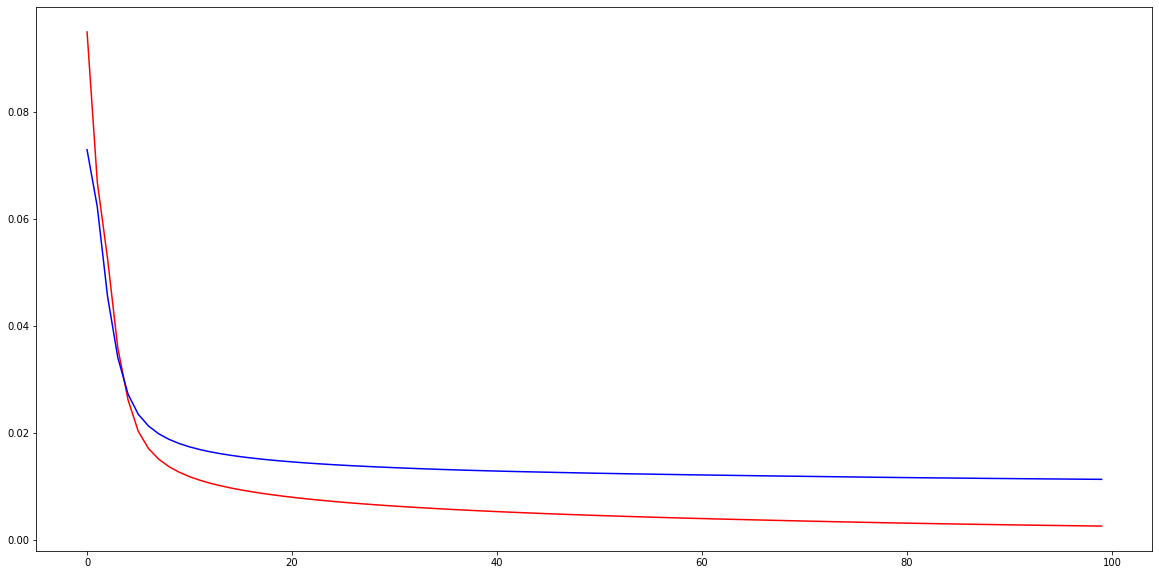

In [20]:
fig = plt.figure(figsize=(20, 10))
plt.plot(range(NUM_EPOCHS), loss_training, color='red')
plt.plot(range(NUM_EPOCHS), loss_test, color='blue')
plt.show()

b) Plot some digits that where classified incorrectly

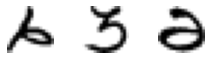

In [28]:
incorrectly_classified = np.argwhere((model.predict(X_test[:100])==y_test[:100])==False)

def show_numbers(X):
    fig = plt.figure(figsize=(20, 6))

    for i in range(len(X)):
        ax = plt.subplot(6, 15, i + 1)
        img = 255 - X[i].reshape((16, 16))
        plt.imshow(img, cmap='gray')
        plt.axis('off')

show_numbers(X_test[incorrectly_classified])

c) Plot your first weight layer as a grayscale image.

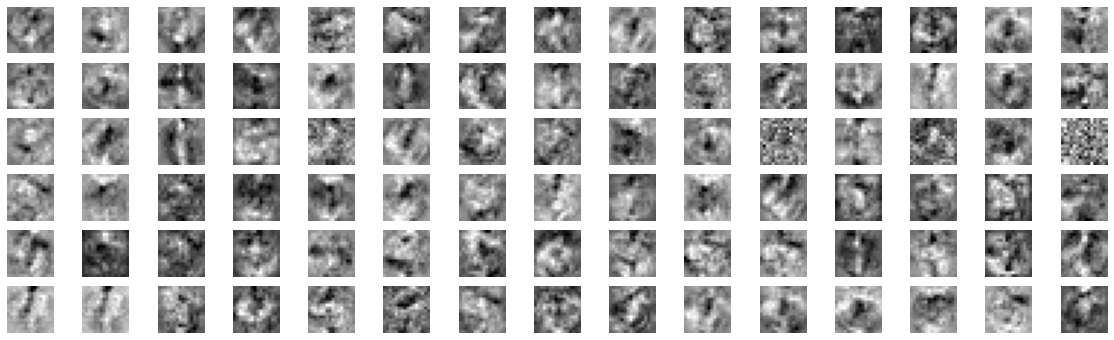

In [41]:
# Now this exercise can be interpreted differently.
# The most reasonable thing would be to plot a 16x16 image
# So we are looking at the weight vector corresponding to each neuron
# in the next layer. Now the weight vector points in the direction
# of the features it extracts.

def show_layer(W):
    fig = plt.figure(figsize=(20, 6))

    for i in range(len(W[0,:])):
        ax = plt.subplot(6, 15, i + 1)
        img = 255 - W[:,i].reshape((16, 16))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
  
show_layer(model.model.layers[0].w[:,:90])


We see that there is definitely some structure in those layers. Some circles, lines, but not features that we would extract. We would look for much cleaner defined shapes. So we see that layers are still hard to interpretate. 